In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import classification_report , confusion_matrix
import itertools
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from utils import *
from grad_cam import *
import io
from PIL import Image as PILImage
import random


In [2]:
def apply_transforms(image):
    train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transform(image)

In [3]:
def apply_test_valid_transforms(image):
    val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return val_test_transform(image)

In [4]:
def custom_collate_fn(batch):
    transformed_images = []
    labels = []
    for image, label in batch:
        transformed_image = apply_transforms(image)
        transformed_images.append(transformed_image)
        labels.append(label)
    return torch.stack(transformed_images), torch.tensor(labels)

In [7]:
data_dir = "C:/Users/Jan/SGH/magisterka/dane/kvasir-dataset-v2/dane"

### Transformacje dla poszczególnych zbiorów

In [8]:
ds = datasets.ImageFolder(data_dir)

In [9]:
class_names = ds.classes
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [11]:
custom_labels = {i: name for i, name in enumerate(class_names)}
custom_labels

{0: 'dyed-lifted-polyps',
 1: 'dyed-resection-margins',
 2: 'esophagitis',
 3: 'normal-cecum',
 4: 'normal-pylorus',
 5: 'normal-z-line',
 6: 'polyps',
 7: 'ulcerative-colitis'}

In [12]:
train_size = int(0.7 * len(ds))
valid_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(ds, [train_size, valid_size, test_size])

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

### Ładowanie pre-wytrenowanego modelu

In [14]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(ds.classes))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definiowanie funkcji straty oraz optymizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

In [16]:
num_epochs = 20

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [18]:
model, model_history = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device)

Epoch [1/20] Train Loss: 1.1039, Train Accuracy: 70.34% Val Loss: 0.6106, Val Accuracy: 82.33%
Epoch [2/20] Train Loss: 0.4992, Train Accuracy: 85.59% Val Loss: 0.4415, Val Accuracy: 86.00%
Epoch [3/20] Train Loss: 0.4014, Train Accuracy: 87.07% Val Loss: 0.3932, Val Accuracy: 85.67%
Epoch [4/20] Train Loss: 0.3380, Train Accuracy: 88.95% Val Loss: 0.3700, Val Accuracy: 86.25%
Epoch [5/20] Train Loss: 0.3211, Train Accuracy: 89.18% Val Loss: 0.3099, Val Accuracy: 89.08%
Epoch [6/20] Train Loss: 0.2909, Train Accuracy: 89.77% Val Loss: 0.3252, Val Accuracy: 88.08%
Epoch [7/20] Train Loss: 0.2602, Train Accuracy: 90.93% Val Loss: 0.3588, Val Accuracy: 87.00%
Epoch [8/20] Train Loss: 0.2600, Train Accuracy: 90.68% Val Loss: 0.2939, Val Accuracy: 89.00%
Epoch [9/20] Train Loss: 0.2333, Train Accuracy: 91.82% Val Loss: 0.2698, Val Accuracy: 89.33%
Epoch [10/20] Train Loss: 0.2414, Train Accuracy: 91.04% Val Loss: 0.3094, Val Accuracy: 87.50%
Epoch [11/20] Train Loss: 0.2167, Train Accuracy:

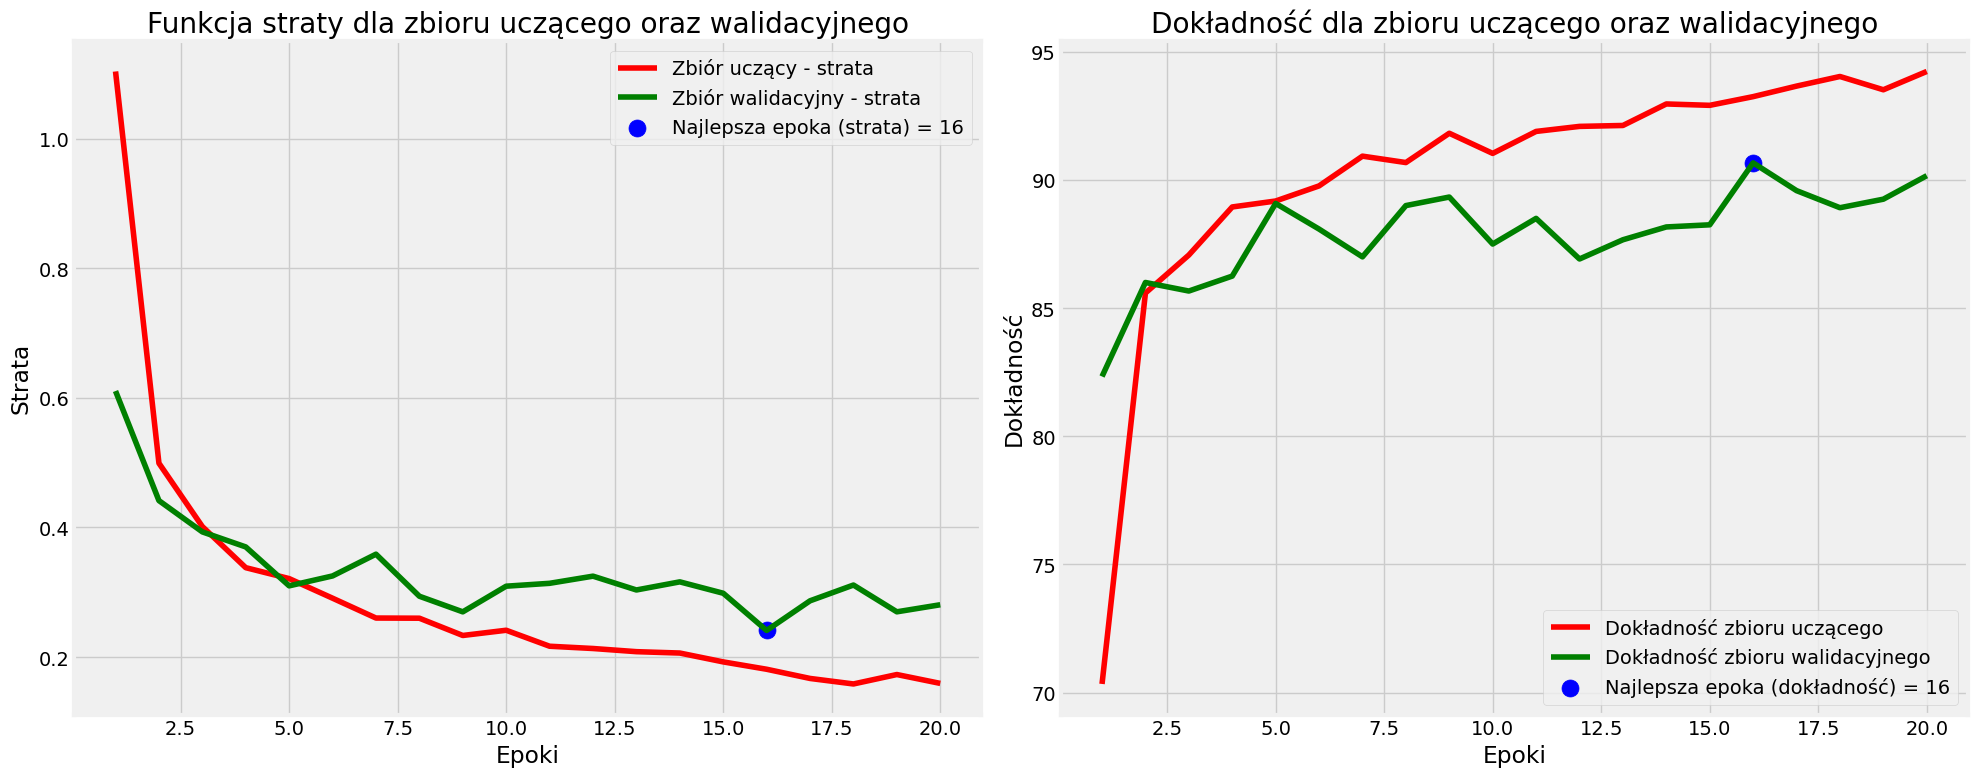

In [19]:
show_loss_accuracy_plots(model_history)

### Testowanie modelu

In [20]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 89.33%


In [21]:
evaluate_model(model, test_loader, device)

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.94      0.92      0.93       144
dyed-resection-margins       0.93      0.94      0.94       166
           esophagitis       0.79      0.82      0.81       162
          normal-cecum       0.90      0.99      0.94       151
        normal-pylorus       0.97      0.98      0.97       135
         normal-z-line       0.82      0.79      0.81       159
                polyps       0.91      0.88      0.89       142
    ulcerative-colitis       0.94      0.87      0.90       141

              accuracy                           0.90      1200
             macro avg       0.90      0.90      0.90      1200
          weighted avg       0.90      0.90      0.90      1200



In [22]:
test_predictions, test_labels = get_predictions_and_labels(model, test_loader, device)

In [23]:
cm_test = confusion_matrix(test_labels, test_predictions)

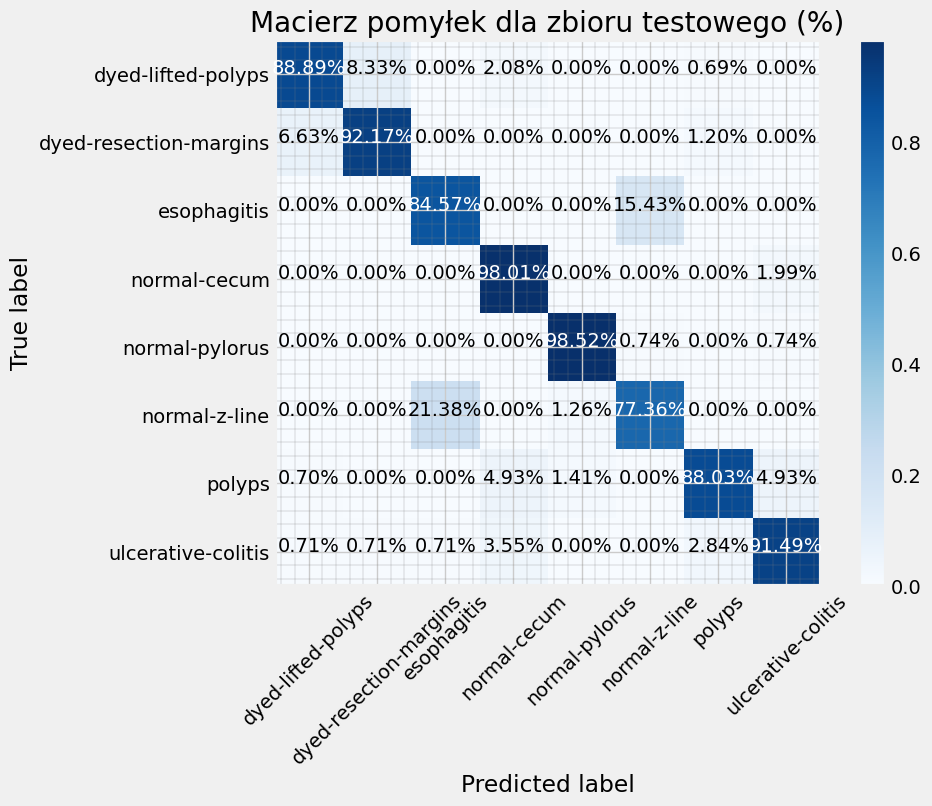

In [24]:
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek dla zbioru testowego (%)')

Label: dyed-lifted-polyps


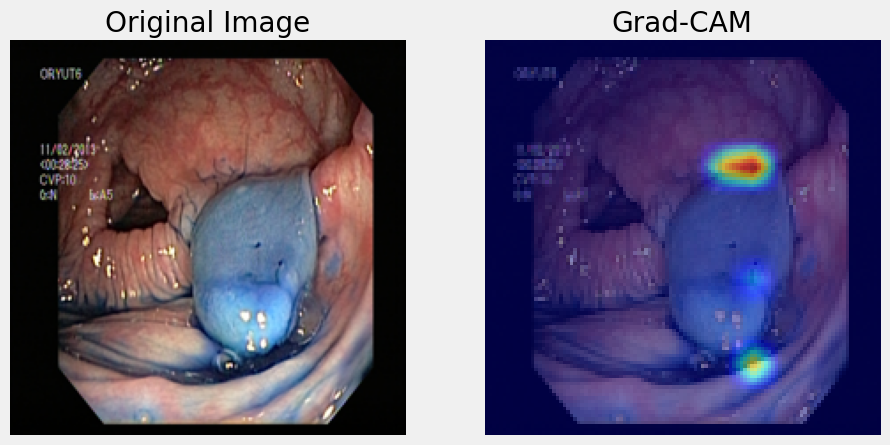

Label: dyed-resection-margins


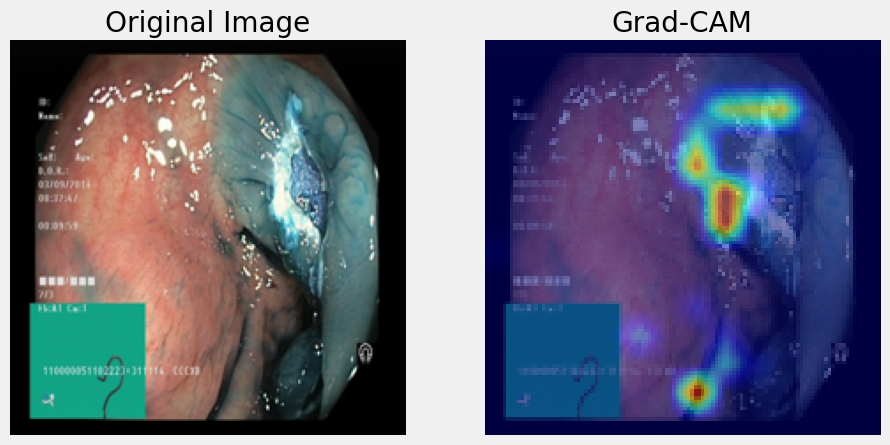

Label: esophagitis


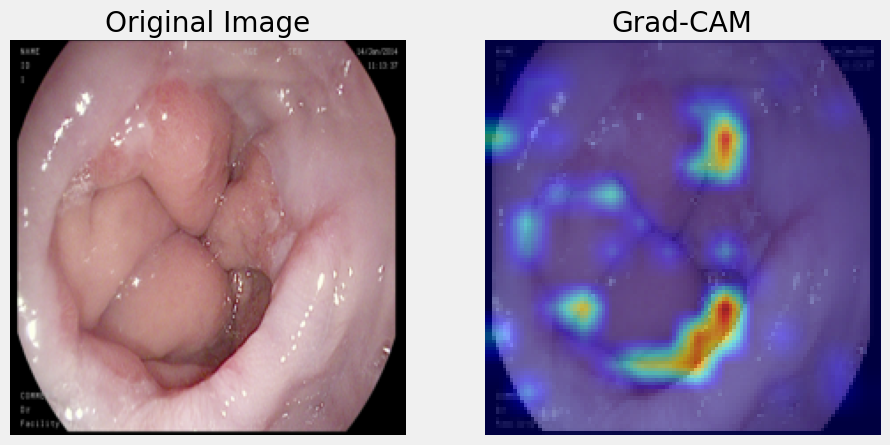

Label: normal-cecum


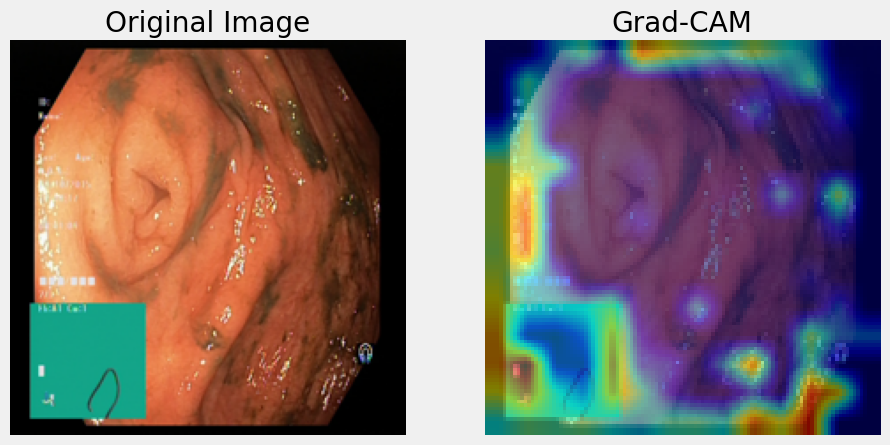

Label: normal-pylorus


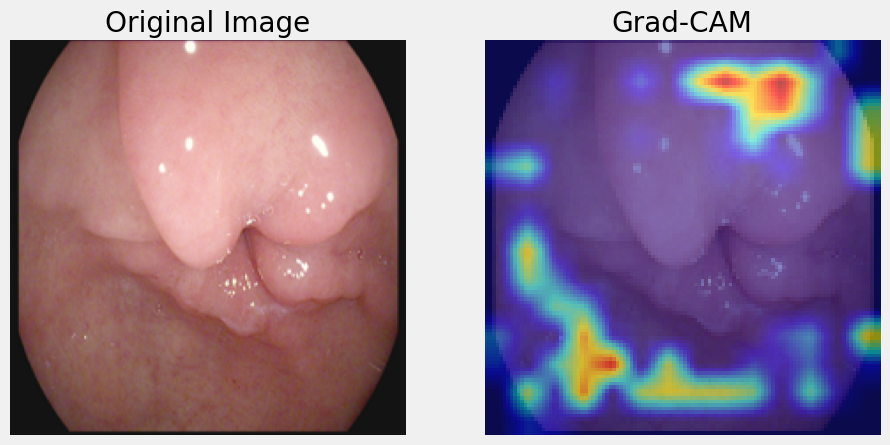

Label: normal-z-line


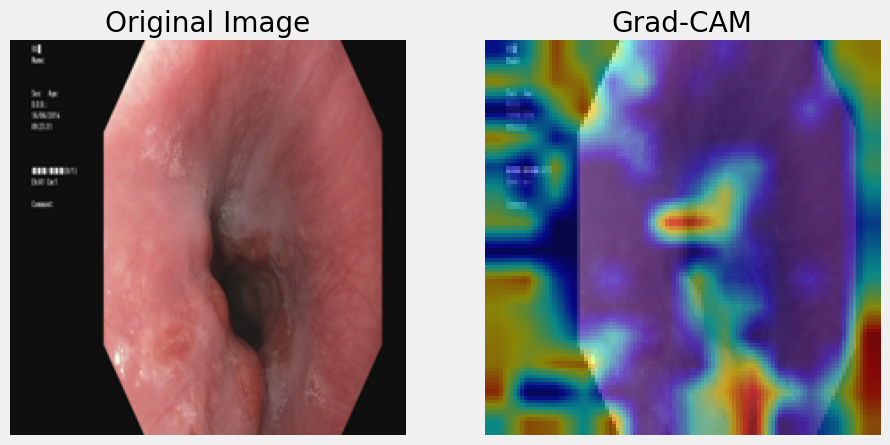

Label: polyps


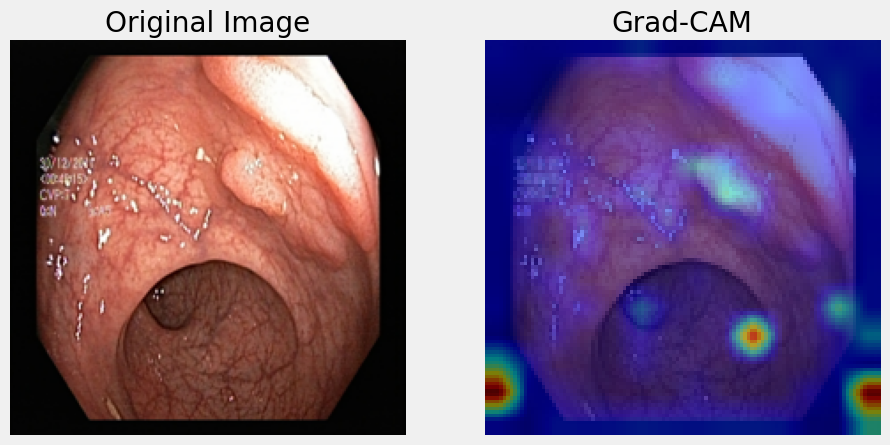

Label: ulcerative-colitis


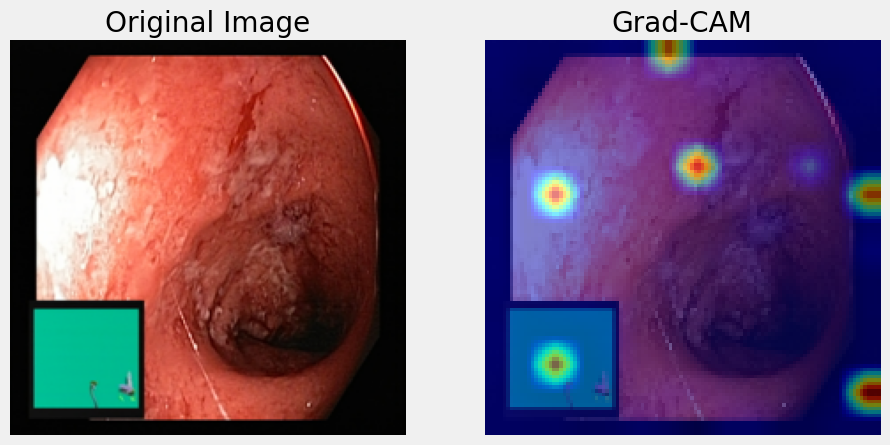

In [26]:
display_images_with_gradcam(model=model, dataset = train_dataset, reshape_transform = reshape_transform_vit_huggingface, custom_labels = custom_labels, num_classes = len(class_names))